In [ ]:
import seedir as sd
import pandas as pd
import pprint
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import tanh
from torch.nn.functional import one_hot
from torch.nn import Linear, Module, Dropout

from datascience.utils import apply, language, city, brand, group, get_folder
from datascience.utils import NotSupportedDataTypeError, NotEqualDataTypeError
from datascience.data_loading import load_dataset, one_hot_encoding
from datascience.data_loading.load_dataset import assert_equal, assert_argument
from datascience.model import DeepLearningModel

import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# Rapport SY23 - Prix d'hotels

## 1 - Introduction

Le projet consiste en l’étude d’un jeu de données de différents hôtels. En effet, plusieurs plaintes ont été reçues par la répression des fraudes d’un pays imaginaires. Ces plaintes ne concernent exclusivement des consommateurs basés en Europe et ayant réalisé des réservations dans des villes Européennes. L’organisme de répression des fraudes informe qu'elle souhaite concentrer les recherches sur 9 villes car, selon leurs experts métier, elles sont révélatrices du marché de l'hôtellerie en Europe.
Afin de pouvoir tester nos différents modèle, une API sera utilisée. Celle-ci permettra via la création d’avatars de pouvoir simuler des recherches d’hôtels d’après plusieurs paramètres (utilisation du téléphone, nationalité de l’avatar, destination et la durée entre le moment de réservation et le début de séjour).  Les requêtes réalisées au moyen de l’API permettront de ressortir une liste d’hôtel avec l’id de celui-ci, son prix et le nombre de chambre disponible.


## 2 - Architecture logicielle

### 2.1 - Architecture de fichiers

Lors de la réalisation de ce projet, nous avons dévelopé un package Python nommé "datascience" qui contient l'ensemble des fonctions et classes dont nous avons besoin pour récupérer les données, traiter les données, créer des modèles de Deep learning, les entrainer et les tester. Ce package est lui-même divisé en 5 sous-parties :

1. data_loading: Ce package sert à charger les données pour pouvoir les utiliser dans les modèles
2. data_recovery: Ce package sert à générer des requetes API pour pouvoir construire un jeu de données
3. model: Ce package fournit des classes abstraites pour pouvoir définir des modèles de Machine Learning
4. utils: Ce package fournit des outils et données utilisables dans les autres packages
5. visualisation: Ce package fournit des fonctions pour pouvoir visualiser le dataset (histogrames)

L'architecture complete du package est disponible via le bloc de code ci-dessous.

In [ ]:
sd.seedir('./datascience', exclude_folders=['__pycache__'], style='emoji')

### 2.2 - Architecture des classes

Pour mener à bien l'ensemble des tâches nécessaires afin de développer des modèles, nous avons implémenté un certain nombre de classes. Les diagrammes de classes ci-dessous montrent les relations entre les classes. 

1. La classe Connector:

![Connector](./img/inria_classe_connector.png)

2. La classe CustomDataset:

![CustomDataset](./img/inria_classe_load_DataSet.png)

3. La classe Data:

![ConDatanector](./img/inria_classe_torch_dataset.png)

3. Les classes de modèle:

![Model](./img/inria_classe-MLmodel.drawio.png)


Ces classes permettent de réaliser l'ensemble des actions pour pouvoir définir et entrainer des modèles de Machine Learning. Cf les parties "Récuperations des données", "Préparation des données", "Chargement des données" et "Modèles" pour voir leurs utilisations.


## 3 - Recuperation des données

### 3.1 - Explication de l'API

L'API mise à disposition par l'INRIA permet de récupérer des informations sur les hôtels et leurs prix. Les requêtes effectuées vers cette API peuvent contenir les arguments suivants:

- city : Nom de la ville où effectuer la recherche d’hôtels. Valeurs : ‘amsterdam’, ‘copenhagen’, ‘madrid’, ‘paris’, ‘rome’, ‘sofia’, ‘valletta’, ‘vienna’ et ‘vilnius’.
- date : Nombre de jours entre la date de la requête et le jour requêté (i.e. le nombre de jour entre le moment où vous regardez sur le site et le jour du check-in). Valeurs : Nombres positifs (entre 44 et 0).
- language : Langue de l’interface. Valeurs : ‘austrian’, ‘belgian’, ‘bulgarian’, ‘croatian’, ‘cypriot’, ‘czech’, ‘danish’, ‘dutch’, ‘estonian’, ‘finnish’, ‘french’, ‘german’, ‘greek’, ‘hungarian’, ‘irish’, ‘italian’, ‘latvian’, ‘lithuanian’, ‘luxembourgish’, ‘maltese’, ‘polish’, ‘portuguese’, ‘romanian’, ‘slovakian’, ‘slovene’, ‘spanish’ or ‘swedish’.
- mobile : Paramètre permettant de simuler une requête réalisée depuis un téléphone portable (au lieu d’un ordinateur). Valeurs : 1 (téléphone) ou 0 (ordinateur).
- avatar : Identifiant d’un utilisateur fictif (e.g. un faux compte client créé).

Nous avons implémenté un module api_connector pour assurer la communication avec l'API. Ce module contient la classe Connector. 
Cette classe est instanciée par un constructeur qui prend en argument une clé API unique obtenue auprès des organisateurs.

La classe contient les methodes suivantes:
- create_avatar : Méthode statique qui fait un appel "POST" à l'API pour créer un nouvel utilisateur fictif (autrement dit avatar).
- get_avatar: Méthode statique qui fait un appel "GET" à l'API et retourne la liste d’avatars déjà disponibles avec leur ids et noms.
- query: Méthode statique qui prend en parametre les critères d'une recherche d'un hôtel et qui réalise un appel "GET" à l'API qui retourne: la liste des hôtels répondants aux critères demandés (identifiant de l'hôtel, prix, nombre de chambres restantes).

Il est important de souligner que une clef API ne peut effectuer que 1000 requêtes par semaine.

### 3.2 - Réalisation et stockage des requêtes API:

Pour pouvoir choisir au mieux les requêtes à effectuer parmi l'ensemble de toutes les requêtes possibles, nous avons implémenté les fonctions suivantes dans le module utils:

Génération d'une liste stockant toutes les combinaisons de paramètres (ville, date, langue, mobile) possibles avec l'API  (9\*45\*27\*2 = 21870 requêtes possibles). Ces requêtes sont stockées dans un fichier possible_api_requests.csv. Un parametre "used" indique pour chaque requête si elle est déjà utilisée. La fonction qui génère ce fichier s'appelle generate_api_requests et n'a été utilisée qu'une seule fois.

In [39]:
from datascience.utils.data import language, city
api_requests = []
for c in city:
    for l in language:
        for i in range(45):
            api_requests.append([c, l, i, 0, 0])
            api_requests.append([c, l, i, 1, 0])
print("10 premiers éléments de la liste:\n")
pprint.pprint(api_requests[:10])
print(f"\nLongueur de api_requests => {len(api_requests)}")

10 premiers éléments de la liste:

[['amsterdam', 'austrian', 0, 0, 0],
 ['amsterdam', 'austrian', 0, 1, 0],
 ['amsterdam', 'austrian', 1, 0, 0],
 ['amsterdam', 'austrian', 1, 1, 0],
 ['amsterdam', 'austrian', 2, 0, 0],
 ['amsterdam', 'austrian', 2, 1, 0],
 ['amsterdam', 'austrian', 3, 0, 0],
 ['amsterdam', 'austrian', 3, 1, 0],
 ['amsterdam', 'austrian', 4, 0, 0],
 ['amsterdam', 'austrian', 4, 1, 0]]

Longueur de api_requests => 21870


A partir d'un fichier répertoriant les hôtels de chaque ville (métadonnées fournies par les organisateurs), nous avons décidé que la répartition de nos requêtes entre les villes doit reflèter la répartition des hôtels entre villes. Par exemple, une ville ayant 35% des hôtels, devra avoir 35% des requêtes. Pour cela, nous avons créé un histogramme permettant de visualiser le nombre d'hôtels par ville (la fonction get_distribution) et un pour visualiser le nombre de requêtes à faire par ville (generate_histo).

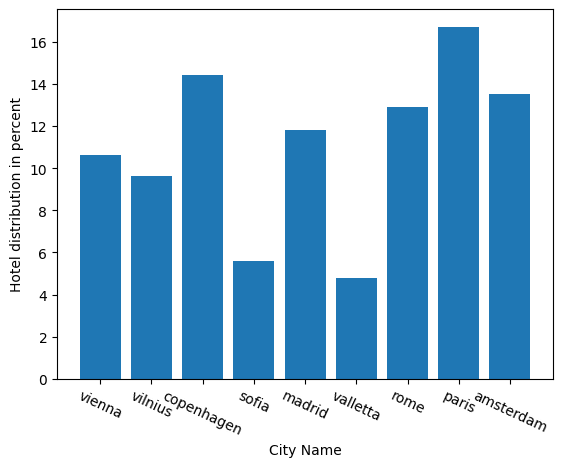

In [78]:
# Ce bloc de code affiche la repartition des hôtels parmi les villes.

hotels = pd.read_csv('./meta_data/features_hotels.csv')
city = hotels["city"].to_numpy()
keys = set(city.tolist())
total_hotel = len(city)
histo = {}


for i in keys:
    nb_hotel = len(list(filter(lambda x: x == i, city)))
    pourcentage = nb_hotel / total_hotel * 100
    histo[i] = pourcentage
    
l = range(len(histo.keys()))
plt.bar(l, histo.values(), align='center')
plt.xticks(l, histo.keys(),rotation = -25)
plt.xlabel("City Name")
plt.ylabel("Hotel distribution in percent")
plt.show()

In [ ]:
# Ce bloc de code affiche la repartition des requêtes parmi les villes


generated_r = pd.read_csv("./meta_data/generated_requests.csv")['city']
histo = {}

for i in generated_r.to_list():
    if i in histo.keys():
        histo[i] += 1
    else:
        histo[i] = 1
total = sum(histo.values())
data = {'city': histo.keys(), 'nb_requests': histo.values()}
distribution = pd.DataFrame.from_dict(data)
distribution['dataset'] = distribution['nb_requests'] / total


Le travail de réalisation des requêtes est confié au package data_recovery qui contient le module recovery.py. Celui-ci contient les fonctions suivantes :
- La fonction request() prend en parametre les valeurs 'city', 'language', 'date' et 'mobile' et appel la fonction query(), qui realise la requete. request() ajoute également les informations récupérées au dossier de l'ensemble de données dataset expliqué plus tard. Elle apporte également d'autres modifications aux fichiers de métadonnées dans le but de suivre l'exécution de la requête (par exemple, la mise à jour du paramètre "used").
- La fonction take_n_requests() qui génère aléatoirement les paramètres pour n requêtes en suivant les distributions des requêtes sur les villes. La fonction crée et affecte également un certain nombre d'avatars d'utilisateurs fictices à ces requêtes en appelant la fonction assigning_avatar(). La fonction retourne finalement l'ensemble de n requêtes à realiser vers l'API.
- La fonction making_n_requests() exécute les n requêtes générées en appelant l'API.
- update_dataset() ajoute les réponses aux n requêtes constituant notre jeu de données dans un fichier du répertoire dataset: dataset/ville/ville_langue.csv comme indiqué par la commande suivante :

In [ ]:
sd.seedir('./dataset', depthlimit=2, itemlimit=3, style='emoji')

In [ ]:
file = "./dataset/amsterdam/amsterdam_austrian.csv"
df = pd.read_csv(file)
pd.options.display.max_columns = len(df.columns)
df

### 3.3 - Préparation des données

Pour preparer les donnees de l'entrainnement et de test de nos modeles, plusieurs implementation ont ete realises:
- La classe CustomDatset dans le module load__dataset.py du package data_loading: Une instance de type CustomDataset est instanciée en lui fournissant la matrice x de features indépendantes et le vecteur dépendant y. La classe contient plusieurs méthodes statiques pour gérer les types de ces matrices ainsi qu'une méthode split qui divise le jeu de données en 2: dataset et testset.
- La fonction apply() du module utils vise à transformer des features qualitatives en features quantitatives. Pour cela nous associons un identifiant numérique unique à chaque ville, à chaque langue, à chaque marque et à chaque groupe. La marque et le groupe de l'hôtel sont des features que nous avons ajoutées à notre jeu de données en consultant d'autres fichiers fournis par les organisateurs.

In [ ]:
pprint.pprint(language)

- La fonction one_hot_encoding() dans le module datascience.data_loading.torch_dataloader vise à encoder les colonnes catégorielles pour arriver a des resultat moins biaisee. L'idée est d'avoir un nombre binaire unique (o ou 1) pour chaque catégorie. Par conséquent, le nombre de chiffres est le nombre de catégories pour l'attribut catégoriel à encoder.
- Finalement, La fonction load_dataset() du module load_dataset.py du package data_loading prend comme paramètres le dossier de jeu de données récupéré depuis l'API et le fichier de features supplémentaires, elle les joint et renvoie un objet de type CustomDataset.

In [ ]:
dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")
dataset.x

In [ ]:
dataset.y

In [ ]:
one_hot_encoding(dataset.x) # dataset.x est la matrice des features indépendantes
# Après le one_hot_encoding : explosion du nombre de features (109 au lieu de 11)

### 4 - Chargement des données
Dans cette partie, nous expliquerons comment ont été chargées les données afin d’être exploiter au mieux par les différents modèles de machine learning (Régression simple, Ridge, Lasso) et deep learning( Deux réseaux de neurones from scratch, un modèle exécuté avec pytorch).

#### 4.1 - Module Load_dataset

Dans un premier temps, l’enjeux était de créer des classes et fonctions permettant de gérer différents types de dataset et d’unifier les données. Mais également d’associer les données générer par les requêtes avec le fichier détaillant les hotels_features.
Ainsi, nous avons créé un module load_dataset, qui sera utile afin de générer les datasets pour les algorithmes de machine learning énumérés précedemment. Dans celui-ci les fonctions suivantes ont été définis :
-	Fonction assert_equal(x,y), permettant de vérifier si x et y sont du même type,
-	Fonction assert_argument(x), permettant de vérifier que le dataset x est soit un numpy array soit un dataframe pandas,
-	Classe **CustomDataset**, se composant d’un constructeur permettant de vérifier la nature des données grâce aux deux fonctions décrient précedemment et également d’une méthode permettant de diviser les sets X et y en training et test. Pour finir cette classe a également une fonction permettant de convertir les dataframe pandas en numpy array.
-	Fonction **load_dataset**(dataset_path, features_hotels, dtype="numpy"), qui prend en input le chemin du dataset issue des requêtes, le chemin du dataset avec les features d’hôtels. Cette fonction permettra de concatener le dataset des requêtes avec celui des caractéristiques des hôtels.

Ainsi, fonction load_dataset sera utilisée et permettra d’avoir donc deux datasets un pour les features :
-	City,
-	date,
-	language,
-	mobile,
-	stock,
-	group,
-	brand,
-	parking,
-	pool,
-	children_policy,
-	order_requests

Et un dataset Y avec les prix associés afin de pouvoir effectuer les algorithmes de regression comme vu ci-après:

In [ ]:
class CustomDataset:
    """ A class to handle dataset using numpy array or pandas Dataframe

    :param x: The features of the dataset
    :param y: The output
    """

    def __init__(self, x, y):
        assert_equal(x, y)
        assert_argument(x)
        assert_argument(y)
        self.x = x
        self.y = y

    def getsize(self):
        """ Calculate the length of the data set

        :return: The length
        :rtype: int
        """
        return self.x.shape[0]

    def split(self, dist=[0.8, 0.2]):
        """ Split the data set in multiple subset

        If n is the number of subset, the list dist should contain n-1 values

        :param dist: A list containg the size of output subset
        :return: A tuple containing all subset
        """
        dist = list(map(lambda x: int(self.getsize() * x), dist))
        for i in range(1, len(dist)):
            dist[i] += dist[i - 1]
        result = []
        if isinstance(self.x, pd.core.frame.DataFrame):
            dist = [0] + dist + [self.getsize()]

            for i in range(1, len(dist)):
                x = self.x.iloc[dist[i - 1]:dist[i], :]
                y = self.y.iloc[dist[i - 1]:dist[i], :]
                x.reset_index(drop=True, inplace=True)
                y.reset_index(drop=True, inplace=True)
                result.append(CustomDataset(x, y))
        elif isinstance(self.x, np.ndarray):
            x_split = np.array_split(self.x, dist)
            y_split = np.array_split(self.y, dist)

            for i in range(len(x_split)):
                result.append(CustomDataset(x_split[i], y_split[i]))

        return tuple(result)

    def to_numpy(self):
        if isinstance(self.x, pd.core.frame.DataFrame):
            self.x = self.x.to_numpy()
            self.y = self.y.to_numpy()

In [ ]:
def load_dataset(dataset_path, features_hotels, dtype="numpy"):
    """ A function to load the dataset directory

    :param dataset_path: The path of the dataset directory
    :param features_hotels: The path of the file containing features of each hotel
    :param dtype: The output data type of the function
    :return: An object containing the dataset in the data type specified in the dtype parameter
    :rtype: CustomDataset
    """
    city_folder = get_folder(dataset_path)
    rows = None
    for i in city_folder:
        language_file = get_folder(f"{dataset_path}/{i}")
        for j in language_file:
            temp = pd.read_csv(f"{dataset_path}/{i}/{j}")
            if rows is None:
                rows = temp.to_numpy()
            else:
                rows = np.concatenate((rows, temp.to_numpy()))

    np.random.shuffle(rows)
    rows = pd.DataFrame(rows,
                        columns=['hotel_id', 'price', 'stock', 'city', 'date', 'language', 'mobile', 'avatar_id',
                                 'order_requests'])
    hotels = pd.read_csv(features_hotels, index_col=['hotel_id', 'city'])
    pricing_requests = rows.join(hotels, on=['hotel_id', 'city'])
    y_data_set = pricing_requests[['price']]
    x_data_set = pricing_requests[[
        'city',
        'date',
        'language',
        'mobile',
        'stock',
        'group',
        'brand',
        'parking',
        'pool',
        'children_policy',
        'order_requests'
    ]]
    x_data_set = x_data_set.applymap(apply)
    if dtype == "numpy":
        return CustomDataset(x_data_set.to_numpy(), y_data_set.to_numpy())
    elif dtype == "pandas":
        return CustomDataset(x_data_set, y_data_set)
    else:
        raise "Wrong data type"
        
dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")
print(dataset.x)
print(dataset.y)

#### 4.2 - DataLoader Pytorch

Dans un second temps, nous avons eu besoin d’utiliser pytorch. Un nouveau package a donc été créée. En effet, la manière de charger les données avec pytorch est assez différente. Nous avons deux objets : DataSet and DataLoader objects.
Avant de détailler le fonctionnement d’un DataLoader pytorch, notons qu’il a été créé une fonction one_hot_encoding(x) qui permettra de faire du one hot encoding sur les caractéristiques suivantes :
-	City,
-	Language,
-	Brand,
-	Group,
-	Children,
-	Date,

La classe DataSet utilisera la fonction load_dataset précédemment définie et ainsi transforma les deux numpy array X et y, correspondant respectivement aux features et aux prix des différents hôtels en tensors mais également de définir au moyen de la méthode get_item différents sample de notre dataset et d’ainsi améliorer le training. 
En effet, faire de nombreuses itérations sur le datset est très couteux en temps. C’est pourquoi, la classe DataSet permettra de diviser le dataset en plusieurs batch qui seront regrouper pour faire des batch. Pour être plus claire, nous allons définir certains termes.
-	Une epoch correspond à un forward et backward pass pour tous les trainings batch,
-	Un batch correspond à une combinaison de sample du dataset,
-	Le batch size est donc le nombre de sample dans un forward et backward pass,
-	Le nombre d’itérations est le nombre de boucle faite sur les différents batch

**Exemple :**
Samples=100,
Batch_size=20,
Nombre d’itérations=100/20=5 pour une epoch

Ainsi, la fonction prepar_data_loader permet d’appeler la classe DataLoader qui divisera les données en différents batch de sample de données et qui fera en sorte d’optimiser le training avec l’option shuffle et num_workers.

In [ ]:
class Data(Dataset):
    def __init__(self, dataset_path, features_hotels, dtype="onehot"):
        dataset = load_dataset(dataset_path, features_hotels, dtype="pandas")

        if dtype == "matrix":
            x = one_hot_encoding(dataset.x)
            x = to_matrix(x)
            self.X = torch.from_numpy(x.astype(np.float32))
        elif dtype == "onehot":
            x = one_hot_encoding(dataset.x)
            self.X = torch.from_numpy(x.to_numpy().astype(np.float32))
        elif dtype == "relative":
            x = relative_column(dataset.x)
            self.X = torch.from_numpy(x.to_numpy().astype(np.float32))
        else:
            raise f"{dtype} => Invalid type for loading test set"

        self.y = torch.from_numpy(dataset.y.to_numpy().astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [ ]:
def prepare_dataloader(dataset_path, features_hotels, dist=[0.8, 0.2], batch_size=64, dtype="onehot"):
    dataset = Data(dataset_path, features_hotels, dtype)
    rep = list(map(lambda x: int(x * dataset.__len__()), dist))
    rep[-1] += dataset.__len__() - sum(rep)

    split = torch.utils.data.random_split(dataset, rep)
    data = []

    for i in split:
        data.append(DataLoader(dataset=i, batch_size=batch_size, shuffle=True, drop_last=True))

    return tuple(data)

#### 4.3 - Test set

Chaque jour, nous avons le droit à un nombre limité de soumissions (5). Ces sousmissions sont faites à partir d'un jeu de données fourni par l'INRIA, et il suffit d'appliquer un modèle de regression sur l'ensemble de ce jeu de données. La fonction load_test_set se trouvant dans le package load_test_set permet de charger le jeu de données de soumission et de le concaténer avec les features des hotels et ensuite d'éffectuer les modifications nécessaires afin de pouvoir les manipuler avec pytorch et de faire les prédictions.

In [ ]:
def load_test_set(test_set='meta_data/test_set.csv', features_hotels='meta_data/features_hotels.csv'):
    to_predict = pd.read_csv(test_set)
    hotels = pd.read_csv(features_hotels, index_col=['hotel_id', 'city'])
    to_predict = to_predict.join(hotels, on=['hotel_id', 'city'])
    to_predict = to_predict.applymap(apply)

    return to_predict['index'], to_predict[[
        'city',
        'date',
        'language',
        'mobile',
        'stock',
        'group',
        'brand',
        'parking',
        'pool',
        'children_policy',
        'order_requests'
    ]]

In [ ]:
from datascience.data_loading.torch_dataloader import one_hot_encoding,relative_column,to_matrix

def torch_test_set(test_set='meta_data/test_set.csv', features_hotels='meta_data/features_hotels.csv', dtype='onehot'):
    index, test_set = load_test_set(test_set, features_hotels)

    if dtype == 'onehot':
        test_set = one_hot_encoding(test_set)
        return index, test_set
    elif dtype == 'matrix':
        test_set = one_hot_encoding(test_set)
        return index, to_matrix(test_set)
    elif dtype == 'relative':
        return index, relative_column(test_set)
    else:
        raise f"{dtype} => Invalid type for loading test set"


In [ ]:
torch_test_set()[1]

## 4 - Les modèles

### 4.1 - Modèles from scrach

#### 4.1.1 - Modèle sous forme de fonction

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm

In [ ]:
def initialisation(dimensions):
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [ ]:
def forward_propagation(X, parametres):
    activations = {'A0': X}

    # C est le nombre de couches si on a 4 paramètres cela signifie qu'on a deux couches
    C = len(parametres) // 2

    for c in range(1, C):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        Z = Z.astype(np.float64)
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    # print(activations)
    Z = parametres['W' + str(C)].dot(activations['A' + str(C - 1)]) + parametres['b' + str(C)]
    Z = Z.astype(np.float64)
    activations['A' + str(C)] = Z
    return activations

In [ ]:
def back_propagation(y, parametres, activations):
    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (
                    1 - activations['A' + str(c - 1)])

    return gradients

In [ ]:
def update(gradients, parametres, learning_rate):
    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [ ]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af

In [ ]:
def prep_data(X, y):
    X_train_transpose = X.T
    Y_train_transpose = y.T
    return X_train_transpose, Y_train_transpose

In [ ]:
def deep_neural_network(X, y, hidden_layers=(16, 16, 16), learning_rate=0.001, n_iter=3000):
    X, y = prep_data(X, y)
    # initialisation parametres
    dimensions = list(hidden_layers)
    # On insert les nombres de coordonnées pour un individu
    dimensions.insert(0, X.shape[0])
    # On donne une sortie
    dimensions.append(y.shape[0])
    np.random.seed(1)
    parametres = initialisation(dimensions)

    # tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 2))

    C = len(parametres) // 2

    # gradient descent
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)

        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]
        print(Af)
        # calcul du log_loss et de l'accuracy
        # print(y.flatten().astype(np.int32).shape)
        # print(Af.flatten().shape)
        training_history[i, 0] = (mean_squared_error(y.flatten().astype(np.int32), Af.flatten(), squared=False))
        y_pred = predict(X, parametres)
        print(y_pred)
        # print(y_pred.flatten().shape)
        # print(y.flatten().astype(np.int32).shape)
        # training_history[i, 1] = (mean_squared_error(y.flatten().astype(np.int32), y_pred.flatten(), squared=False))

    y_pred = predict(X, parametres)
    print(y_pred)
    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    # plt.plot(training_history[:, 1], label='train acc')
    # plt.legend()
    plt.show()

    return parametres

In [ ]:
from datascience.model import MLModel
class AmbreNet(MLModel):
    def __init__(self, dataset='./dataset', features_hotels='./meta_data/features_hotels.csv'):
        super().__init__(dataset=dataset, features_hotels=features_hotels)
        self.parametres = None
        #self.dataset.x = one_hot_encoding(self.dataset.x)
        self.dataset.to_numpy()

    def train(self, hidden_layers=(16,16), learning_rate=0.01):
        self.parametres = deep_neural_network(self.dataset.x, self.dataset.y, hidden_layers=hidden_layers,
                                              learning_rate=learning_rate,
                                              n_iter=2)

    def predict(self, x):
        return predict(x, self.parametres)

In [ ]:
model = AmbreNet()
model.train()

#### 4.1.1 - Modèle sous forme de classe

Pour donner suite à l'implementation from scractch de réseaux de neurones en utilisant des fonctions (cf 4.1.1) comme nous avons vu en TP et en cours. Nous avons décidé de développé un packages python permettant d'implementer des réseaux de neuronnes comme on le ferait si on utilisait un framework python comme Pytorch ou keras/tensorflow. 

Ce package se base sur l'utilisation de la programation orientée objet classique (classe, heritage, polymorphisme, etc..) ainsi que sur l'utilisation de patrons de conception (Streategy) pour permettre une plus grande modularité du code.

On a identifié différents elements necessaires pour pouvoir implementer un réseau de neurones (ci-apres):
1. Fonction d'activation
2. Fonction d'erreur
3. Méthode d'optimisation
4. Le type de couche
5. L'apprentissage (backpropagation)

On a donc défini des sous-packages pour chaque element. Voici l'architecture global du package (UTTnet).

In [ ]:
sd.seedir('./UTTnet', exclude_folders=['__pycache__'], style='emoji')

Chaque sous-package fonctionne sur le même principe. Pour comprendre comment fonctionne le package UTTnet il faut comprendre comment fonctionne le patron de conception statregie dont voici le diagramme UML.

![Strategy](./img/Strategy_Pattern_in_UML.png)

Ce patron de conception permet de garantir la modularité du code en permettant l'implementation de nouveaux types d'objets tant qu'ils respectent certaines conditions (heritage une interface).

Dans le cas de ce package, nous avons adapté le patron de conception pour qu'il réponde à nos besoins. Nous allons parcourir les sous-packages dans l'odre pour expliquer leurs fonctionnement et leurs buts:

1. Metric: Ce sous-packages contient les classes pour implemnter à la fois les fonction d'erreurs et les metriques d'évaluation.

![Metric](./img/uttnet-metric.png)

2. Activation: Ce sous-package contient les classes necessaires pour implemnter différentes fonctions d'activations. Les classes sont utilisées à la fois pour la forward et la backward pass.

![Activation](./img/uttnet-Activation.png)

3. Layer: Ce sous-package contient l'ensemble des classes pour implementer différents types de couches. 

![Layer](./img/uttnet-Layer.png)

4. Optimizer: Ce sous-package contient les classes permettant de réaliser l'optimisation des poids des couches selon différentes méthodes.

![Optimizer](./img/uttnet-optim.png)


Maintenant que l'on a défini l'ensemble des sous packages, on peut representer la classe Network qui rassemble l'ensemble des classes vues précedement pour pouvoir implementer un réseau de neurones complet.

![Network](./img/uttnet-Network.png)

Il suffit d'instancier la classe Network puis de ajouter des couches avec la méthode add pour définir un réseau de neurones. Voici un exemple simple de réseau de neurones utilisant ce package en modelisant un xor. On commence par tester sur un probleme xor, car c'est un probleme tres simple et cela permet de vérifier que le package fonctionne bien.

In [ ]:
from UTTnet import Network
from UTTnet.Activation import Tanh
from UTTnet.Metric import Mse
from UTTnet.Layer import Dense
from UTTnet.Optimizer import SGD

# We are going to test out module on a xor problem

x_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# Define the network
# Loss function is Mean Squared Error
# Optimizer is Stochastic Gradient Descent
model = Network(
    loss=Mse(),
    optimizer=SGD(learning_rate=0.1)
)

# Add two layers
# First layer 2 input and 3 output using tanh activation function and bias is set to true
model.add(Dense(2, 3, activation=Tanh()))
# Second layer 3 input and 1 output using tanh activation function and bias is set to true
model.add(Dense(3, 1, activation=Tanh()))

# Print the model
print(model)

# Train the model
loss = model.fit(x_train, y_train, epochs=1000)
# test the model on
out = model(x_train)
print(out)

In [ ]:
from UTTnet import Network
from UTTnet.Activation import Tanh,Relu
from UTTnet.Metric import Mse
from UTTnet.Layer import Dense
from UTTnet.Optimizer import SGD
from datascience.data_loading import one_hot_encoding
from datascience.data_loading import load_dataset
dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")
dataset.x = one_hot_encoding(dataset.x)
dataset.to_numpy()

In [ ]:
model_2 = Network(
    loss=Mse(),
    optimizer=SGD()
)

model_2.add(Dense(109,109,activation=Tanh()))
model_2.add(Dense(109,1))


loss = model_2.fit(dataset.x[:1500], dataset.y[:1500], epochs=5)
# test the model on
out = model_2(dataset.x[2000])
print(f"x = {dataset.x[2000]}")
print(f"prediction = {out}")
print(f"true = {dataset.y[2000]}")

### 4.2 - Modèles de Machine Learning

### 4.2.1 - Regression lineaire

In [ ]:
import warnings
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from datascience.data_loading import load_test_set, load_dataset
warnings.filterwarnings("ignore")

model = linear_model.LinearRegression()

dataset = load_dataset('dataset/', 'meta_data/features_hotels.csv', dtype="numpy")

index = int(0.2 * len(dataset.x))
dataset.x = dataset.x[:index]
dataset.y = dataset.y[:index]
        
train_set, valid_set = dataset.split(dist=[0.90])

model.fit(train_set.x,train_set.y)

y_predicted=[]
for i in valid_set.x:
    prediction = model.predict([i])
    y_predicted.append(prediction[0])
rmse = mean_squared_error(valid_set.y, y_predicted, squared=False)

print(rmse)

### 4.2.2 - Regression Poly

In [ ]:
import warnings
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from datascience.model import MLModel
from datascience.utils import apply
warnings.filterwarnings("ignore")


class Regression(MLModel):
    def __init__(self, degree, dataset='dataset/', features_hotels='meta_data/features_hotels.csv'):
        super().__init__(dataset, features_hotels)
        self.dataset.to_numpy()
        index = int(0.2 * len(self.dataset.x))
        self.dataset.x = self.dataset.x[:index]
        self.dataset.y = self.dataset.y[:index]
        self.train_set, self.valid_set = self.dataset.split(dist=[0.98])
        self.model = linear_model.LinearRegression()
        self.poly_model = PolynomialFeatures(degree)

    def train(self):
        poly_x_train = self.poly_model.fit_transform(self.train_set.x)
        self.model.fit(poly_x_train, self.train_set.y)

    def predict(self, x):
        poly_x_predict= self.poly_model.fit_transform([x])

        return self.model.predict(poly_x_predict)[0]

    def validate(self):
        return super().validate(self.valid_set.x, self.valid_set.y)


rmse=[]
for i in range(1,5):
    model = Regression(i)
    model.train()
    rmse.append(model.validate())

plt.title("RMSE en fonction du degree de la regression polynomiale")

plt.plot(range(1,5), rmse, color="blue")

plt.show()

### 4.2.3 - Regression Ridge

### 4.2.4 - Regression Lasso

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

dataset = load_dataset('./dataset','./meta_data/features_hotels.csv', dtype="pandas")

def lass(x_set,y_set,percentage,fold):
    X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=percentage, random_state=10)
    # We are using LassoCV with 5 folds but we could also try with 10 folds
    model = LassoCV(cv=fold, random_state=0, max_iter=10000)
    # Fit model
    model.fit(X_train, y_train)
    # We are using the best value of alpha 
    lasso_best = Lasso(alpha=model.alpha_)
    lasso_best.fit(X_train, y_train)
    #Here are the coeff of the lasso regression per metrics
    print(list(zip(lasso_best.coef_, x_set)))
    #Compute the RMSE
    rmse = mean_squared_error(y_test,  lasso_best.predict(X_test), squared=False)
    print(rmse)
    

In [ ]:
lass(dataset.x,dataset.y,0.3,5)
#lass(x_data_set,y_data_set,0.2,10)

### 4.3 - Modèles pytorch

In [ ]:
class NNModel(Module):
    def __init__(self):
        super().__init__()
        self.input = Linear(109, 109)
        self.output = Linear(109, 1)
        self.dropout = Dropout(0.2)

    def forward(self, x):
        x = tanh(self.input(x))
        return self.output(x)

    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()


epochs=10
model = NNModel()
nn = DeepLearningModel(model)
loss_values, val_loss_values = nn.train(epochs=epochs, learning_rate=0.001, batch_size=16, show=True)
x = list(range(1, epochs + 1))
plt.plot(x, loss_values, color='b', label='train')
plt.plot(x, val_loss_values, color='r', label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()